In this tutorial, I illustrate the Markov chain approach to solve the hydro-thermal power system planning problem. Five pre-trained approximating MCs are in the data/MC directory, corresponding to the five models in my paper. For illustration purpose, I use the \#5 MCs(the most coarse one) here and solve the problem for just 30 iterations and 1 step per iteration.

In [2]:
import pandas
import numpy
import gurobipy
from msppy.msp import MSLP
from msppy.solver import SDDP
from msppy.evaluation import Evaluation,EvaluationTrue

gamma = numpy.array(pandas.read_csv(
    "./data/gamma.csv",
    names=[0,1,2,3],
    index_col=0,
    skiprows=1,
))
sigma = [
    numpy.array(pandas.read_csv(
        "./data/sigma_{}.csv".format(i),
        names=[0,1,2,3],
        index_col=0,
        skiprows=1,
    )) for i in range(12)
]
exp_mu = numpy.array(pandas.read_csv(
    "./data/exp_mu.csv",
    names=[0,1,2,3],
    index_col=0,
    skiprows=1,
))
hydro_ = pandas.read_csv("./data/hydro.csv", index_col=0)
demand = pandas.read_csv("./data/demand.csv", index_col=0)
deficit_ = pandas.read_csv("./data/deficit.csv", index_col=0)
exchange_ub = pandas.read_csv("./data/exchange.csv", index_col=0)
exchange_cost = pandas.read_csv("./data/exchange_cost.csv", index_col=0)
thermal_ = [pandas.read_csv("./data/thermal_{}.csv".format(i), index_col=0) for i in range(4)]
hist = [pandas.read_csv("./data/hist_{}.csv".format(i), index_col=0, sep=';') for i in range(4)]
stored_initial = numpy.array(hydro_['INITIAL'][:4])
inflow_initial = numpy.array(hydro_['INITIAL'][4:8])
Markov_states = [pandas.read_csv("./data/MC/5/Markov_states_{}.csv".format(i), index_col=0).values for i in range(120)]
transition_matrix = [pandas.read_csv("./data/MC/5/transition_matrix_{}.csv".format(i), index_col=0).values for i in range(120)]

T = 120
def generator(random_state,size):
    inflow = numpy.empty([size,T,4])
    inflow[:,0,:] = inflow_initial[numpy.newaxis:,]
    for t in range(T-1):
        noise = numpy.exp(random_state.multivariate_normal(mean=[0]*4, cov=sigma[t%12],size=size))
        inflow[:,t+1,:] = noise * (
            (1-gamma[t%12]) * exp_mu[t%12]
            + gamma[t%12] * exp_mu[t%12]/exp_mu[(t-1)%12] * inflow[:,t,:]
        )
    return inflow

HydroThermal = MSLP(T=T, bound=0, discount=0.9906)
HydroThermal.add_Markovian_uncertainty(generator)
for t in range(T):
    m = HydroThermal[t]
    stored_now, stored_past = m.addStateVars(4, ub=hydro_['UB'][:4], name="stored")
    spill = m.addVars(4, obj=0.001, name="spill")
    hydro = m.addVars(4, ub=hydro_['UB'][-4:], name="hydro")
    deficit = m.addVars(
        [(i,j) for i in range(4) for j in range(4)],
        ub = [
            demand.iloc[t%12][i] * deficit_['DEPTH'][j]
            for i in range(4) for j in range(4)
        ],
        obj = [
            deficit_['OBJ'][j]
            for i in range(4) for j in range(4)
        ],
        name = "deficit")
    thermal = [None] * 4
    for i in range(4):
        thermal[i] = m.addVars(
            len(thermal_[i]),
            ub=thermal_[i]['UB'],
            lb=thermal_[i]['LB'],
            obj=thermal_[i]['OBJ'],
            name="thermal_{}".format(i)
        )
    exchange = m.addVars(5,5, obj=exchange_cost.values.flatten(),
        ub=exchange_ub.values.flatten(), name="exchange")
    thermal_sum = m.addVars(4, name="thermal_sum")
    m.addConstrs(
        thermal_sum[i] == gurobipy.quicksum(thermal[i].values()) for i in range(4)
    )
    for i in range(4):
        m.addConstr(
            thermal_sum[i]
            + gurobipy.quicksum(deficit[(i,j)] for j in range(4))
            + hydro[i]
            - gurobipy.quicksum(exchange[(i,j)] for j in range(5))
            + gurobipy.quicksum(exchange[(j,i)] for j in range(5))
            == demand.iloc[t%12][i]
        )
    m.addConstr(
        gurobipy.quicksum(exchange[(j,4)] for j in range(5))
        - gurobipy.quicksum(exchange[(4,j)] for j in range(5))
        == 0
    )
    m.addConstrs(
        (stored_now[i] + spill[i] + hydro[i] - stored_past[i] == 0 for i in range(4)),
        uncertainty_dependent=[0,1,2,3],
    )
    if t == 0:
        m.addConstrs(stored_past[i] == stored_initial[i] for i in range(4))

HydroThermal.discretize(
    method='input',
    Markov_states=Markov_states,
    transition_matrix=transition_matrix,
)
HT_sddp = SDDP(HydroThermal)
HT_sddp.solve(
    logFile=0,
    n_processes=1,
    n_steps=1,
    max_iterations=30,
)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

----------------------------------------------------------------
                   SDDP Solver, Lingquan Ding                   
----------------------------------------------------------------
   Iteration               Bound               Value        Time
----------------------------------------------------------------
           1      1582396.667039    843623373.178456    5.606532
           2      2302827.400358    605923420.977798    3.176518
           3      3281324.066001    554698969.322461    2.886343
           4      5326622.348240    621233949.272867    2.855397
           5      5523420.215889    197012267.238842    2.533289
           6     10123176.788487    204788961.806366    2.840785
           7     37233395.518599    447127213.832364    2.578339
           8     39946569.854153    304163703.565022    2.684920
           9     43508146.416478    337802802.136957    2.759030
          10     46351793.683639    168074955.717974    2.730032
          11     49112057

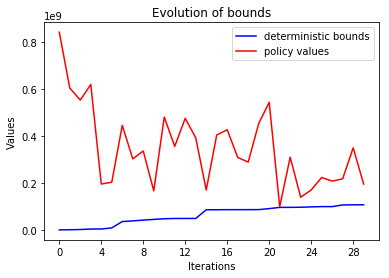

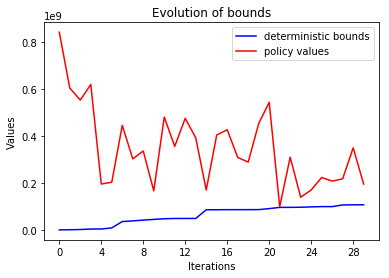

In [4]:
%matplotlib inline
HT_sddp.plot_bounds(window=1,smooth=1)

In [7]:
result = Evaluation(HydroThermal)
result.run(random_state=666, n_simulations=100)
resultTrue = EvaluationTrue(HydroThermal)
resultTrue.run(random_state=666, n_simulations=100)

In [8]:
result.gap, result.CI

(1.5448162340284377, (231162333.88618, 276271182.21123624))

In [9]:
resultTrue.CI

(250779329.1288679, 313507638.5282916)